# Evaluation - Notebook

Within this document, we carry out an assessment of the implemented models. Furthermore, hyperparameter optimization is executed for each model wherever feasible. The following models are subjected to evaluation:

1. Moving Average
2. Various variants of linear regression
3. Neural Network
4. XGBoost
5. LSTM

For a more detailed description of the models, please refer to their corresponding section.

In [1]:
# TODO: look into pipeline framework for hyperparameter tuning
# ###: 3. Different Features (difficult) -> solution might be time-series split
#                                        -> solution: power set of features and normal hyperparameter tuning
# TODO: User can choose which data set and which turbine to use
# TODO: try the transfer learning approach
# TODO: Plotting
# TODO: implement more models
# TODO: implement command line interface - optional
# TODO: implement logging - optional
# TODO: Documentation
# TODO: Hand-in

### Author: Harald Kugler

In [2]:
### imports
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import TimeSeriesSplit

import warnings
warnings.filterwarnings('ignore')

import sys

sys.path.append("..")
sys.path.append("../src")

from src.DataHandling.loading import load_data  # loading
import src.DataHandling.visualization as vis  # plotting
from src.Models.selection import GridSearch  # hyperparameter tuning

### models
from src.Models.ma import MovingAverage
from src.Models.lr import Regression
from src.Models.nn import NeuralNetwork, LSTM
from src.Models.xgb import XGB

### Transformers
from src.DataHandling.preprocessing import (
    DataCleaner,
    SupervisedTransformer,
    Normalizer,
    train_test_split,
)

Prior to the assessment of the models, we have to make a few considerations regarding related to the data:

We decide to leverage the pipeline framework provided by sklearn (QUELLE). This enhances the convenience of tasks such as hyperparameter optimization and effectively utilizing the models. Consequently, all data transformations tailored to this project have been developed in a manner consistent with the transformers found in sklearn.preprocessing. Overall, three specific transformers where implemented:

1. __DataCleaner__: This transformer effectively executes all the steps outlined in ``data_inspection.ipynb``, resulting in a cleaned dataset free of NaN values. Note that employing this transformer could potentially alter the dataset's shape.
2. __SupervisedTransformer__: Given that we are working with time series data, it is necessary to preprocess the dataset to make it suitable for supervised learning algorithms like linear regression. This transformer accomplishes this by introducing new columns that contain shifted versions of the dataset. The number of shifts applied is determined by the "window_size" attribute. Furthermore, the transformer holds a "horizon" attribute, which specifies the number of time steps into the future the model should predict. This attribute determines the magnitude of the first shift applied to the dataset. Note that performing a transform changes the dataset's shape by design. A demonstration of this transformer is provided below.
3. __Normalizer__: This class is a subclass of the StandardScaler transformer in sklearn.preprocessing, which enhances its functionality by allowing it to return a pandas DataFrame when you call the transform(X) method. In that way no information about column names and index is lost.

Additionally, the PolynomialFeatures transformer is used.


In the following you can set the ID of the turbine you want to analyze for each dataset. Be aware that benchmarks are only provided for the second turbine within the Kelmarsh dataset and the first in the Beberine dataset.

In [3]:
### set global variables here ###
TURBINE_ID_BRITISH = 2
TURBINE_ID_BRAZILIAN = 1

In [4]:
# load data
data_brit = load_data(turbine_id=TURBINE_ID_BRITISH, which_data="British")
data_braz = load_data(turbine_id=TURBINE_ID_BRAZILIAN, which_data="Brazilian")

cleaner = DataCleaner(
    features=["Power (kW)", "Wind speed (m/s)"],
    rename_features=["power", "wind_speed"],
)
turbine_brit = cleaner.transform(data_brit)

cleaner = DataCleaner(
    features=["active_power_total", "wind_speed"],
    rename_features=["power", "wind_speed"],
)
turbine_braz = cleaner.transform(data_braz)
turbine_brit.shape, turbine_braz.shape

((286187, 2), (52560, 2))

For understandibility.... models do transformation to a supervised learning problem inherently...

In [5]:
benchmarks = pd.read_csv("../results/benchmarks.csv")
test_start = benchmarks["test_start"][0]
test_end = benchmarks["test_end"][0]

X_train, y_train, X_test, y_test = train_test_split(
    df=turbine_brit, test_start=test_start, test_end=test_end, target_var="power"
)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((233627, 2), (233627,), (52560, 2), (52560,))

Now, we would like to begin with evaluating models. To this in a scientific manner we perform a gridsearch over a discrete set of hyperparameters. 

In [6]:
# set up parameters that are the same for all models
param_grid = {
    "st__window_size": [1, 5, 50],
    "st__horizon": [1, 6, 144],
}

## 1. Moving Average

**Explanation of the Model:** 

In contrast to the Baseline model, the Moving Average model offers the flexibility of selecting a window size. This window size determines the number of preceding time steps taken into account for generating forecasts. Furthermore, there is an option to specify a discount factor (default = 1), which regulates the extent of reduction in influence for more distant past time steps. This strategy is similar to how a discount factor is used in calculating future rewards within the framework of reinforcement learning. Note that when a window size of one is chosen, the Moving Average model is identical with the Baseline model.

In [7]:
### WARNING - takes a long time to run ###
### ~ 10 min on my machine but I have a slow CPU (intel i5, 1.6 GHz) ###
### results dataframe is stored in csv file (also in repo) ###
do_gridsearch = False  # set to True if you want to run the gridsearch

ma_pipe = Pipeline(
    [
        ("st", SupervisedTransformer()),
        ("Model", MovingAverage()),
    ]
)
param_grid["Model__discount"] = np.round(np.linspace(0.7, 1.0, 5), 2)
grid_search_ma = GridSearch(ma_pipe, param_grid)

if do_gridsearch:
    grid_search_ma.fit(X_train, y_train, X_test, y_test, verbose=True)
    grid_search_ma.results.to_csv("../results/results_gs_ma.csv")
else:
    grid_search_ma.update(pd.read_csv("../results/results_gs_ma.csv").set_index(list(param_grid.keys())))

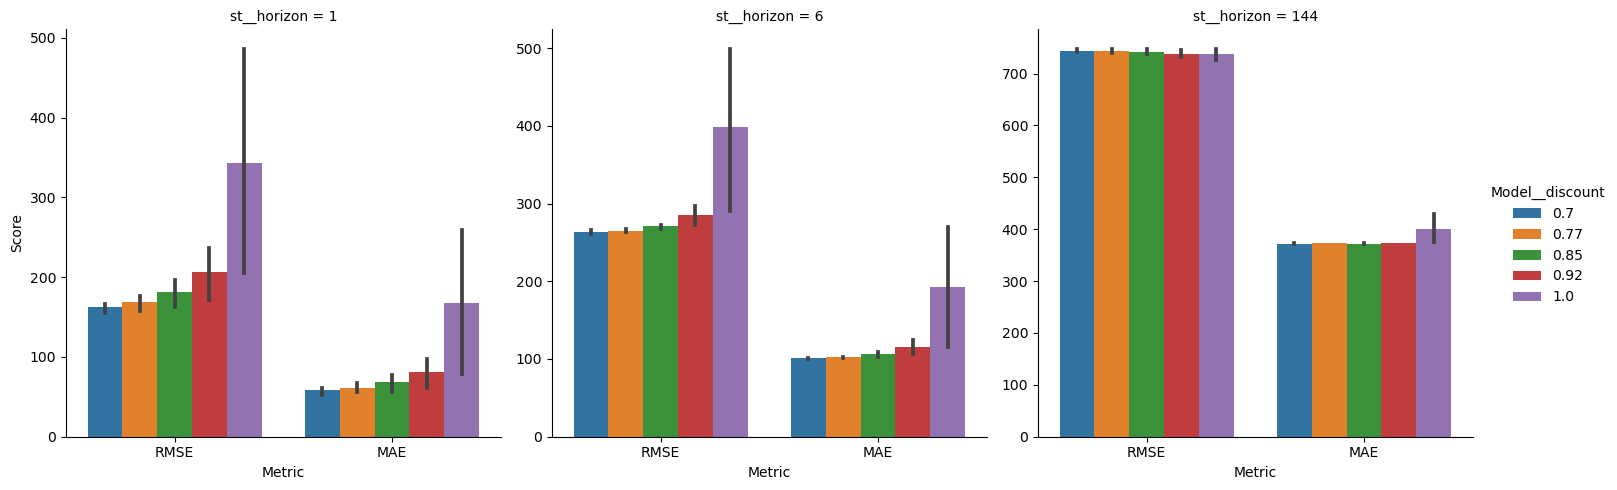

In [8]:
vis.plot_gridsearch(
    results_df=grid_search_ma.results,
    hue="Model__discount",
    col="st__horizon",
    row=None,
    sharey=False,
)

**Analysis:**
- window_size has the most influence for $discount = 1$. This makes sense as all steps in the past have the same impact on the results as the last step. Intuitively there should be a discount smaller than 1. 

In [9]:
# delete key of param_grid that is specific to the model
del param_grid["Model__discount"]

## 2. Various variants of Linear Regression

**Explanation of the Models:**

1. Linear Regression: 
2. Ridge Regression:
3. Lasso Regression: state objective --- Note, that there exists no closed-form solution. 
4. Remarks to Computational Complexity:
    - Discussed Regression variants have complexity $O(m^3)$ where $m$ is #features.
    - That is why large window_sizes (like 500) might become a problem. Computational complexity is then $O((500 \cdot len(features))^3)$ which is not feasible anymore.
    - Kernel Linear Regression

In [10]:
### WARNING - takes a long time to run ###
### ~ 20 min on my machine but I have a slow CPU (intel i5, 1.6 GHz) ###
### results dataframe is stored in csv file (also in repo) ###
do_gridsearch = False  # set to True if you want to run the gridsearch

lr_pipe = Pipeline(
    [
        ("normalizer", Normalizer()),
        ("st", SupervisedTransformer()),
        ("pf", PolynomialFeatures()),
        ("Model", Regression()),
    ]
)

param_grid["pf__degree"] = [1, 2]
param_grid["Model__model"] = ["linear", "ridge"]
param_grid["st__window_size"] = [1, 5, 50]
# param_grid["Model__alpha"] = np.logspace(-3, 1, 5)

grid_search_lr = GridSearch(model=lr_pipe, param_grid=param_grid)

if do_gridsearch:
    grid_search_lr.fit(X_train, y_train, X_test, y_test, refit=False, verbose=True)
    ### store results dataframe in csv file
    grid_search_lr.results.to_csv("../results/results_gs_lr.csv")
else:
    grid_search_lr.results = pd.read_csv("../results/results_gr_lr.csv").set_index(
        list(param_grid.keys())
    )

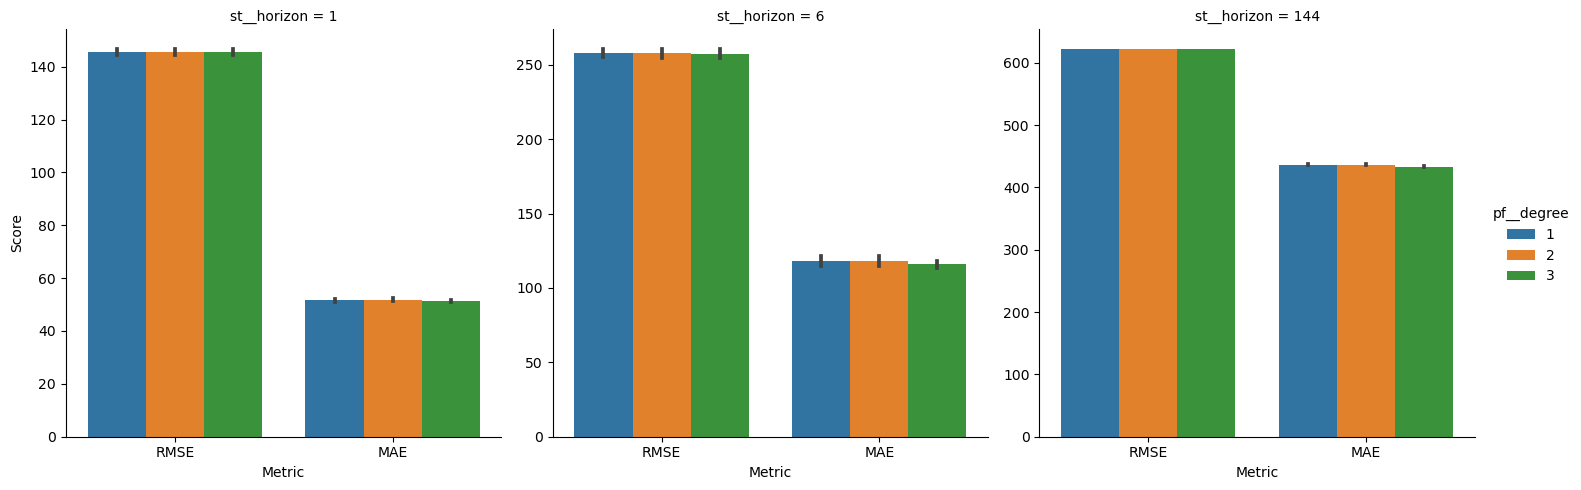

In [11]:
vis.plot_gridsearch(
    results_df=grid_search_lr.results,
    hue="pf__degree",
    col="st__horizon",
    row=None,
    sharey=False,
)

In [12]:
# delete keys of param_grid that is specific to the model
del param_grid["Model__model"]
# del param_grid["Model__alpha"]
del param_grid["pf__degree"]

## 3. XG Boost Regression

**Explanation of the Model:**


In [13]:
do_gridsearch = False  # set to True if you want to run the gridsearch

xgb_pipe = Pipeline(
    [
        ("normalizer", Normalizer()),
        ("st", SupervisedTransformer()),
        ("Model", XGB()),
    ]
)

grid_search_xgb = GridSearch(model=xgb_pipe, param_grid=param_grid)
if do_gridsearch:
    grid_search_xgb.fit(X_train, y_train, X_test, y_test, verbose=True, refit=False)
    # store results
    grid_search_xgb.results.to_csv("../results/results_gs_xgb.csv")
else:
    grid_search_xgb.update(pd.read_csv("../results/results_gs_xgb.csv").set_index(list(param_grid.keys())))

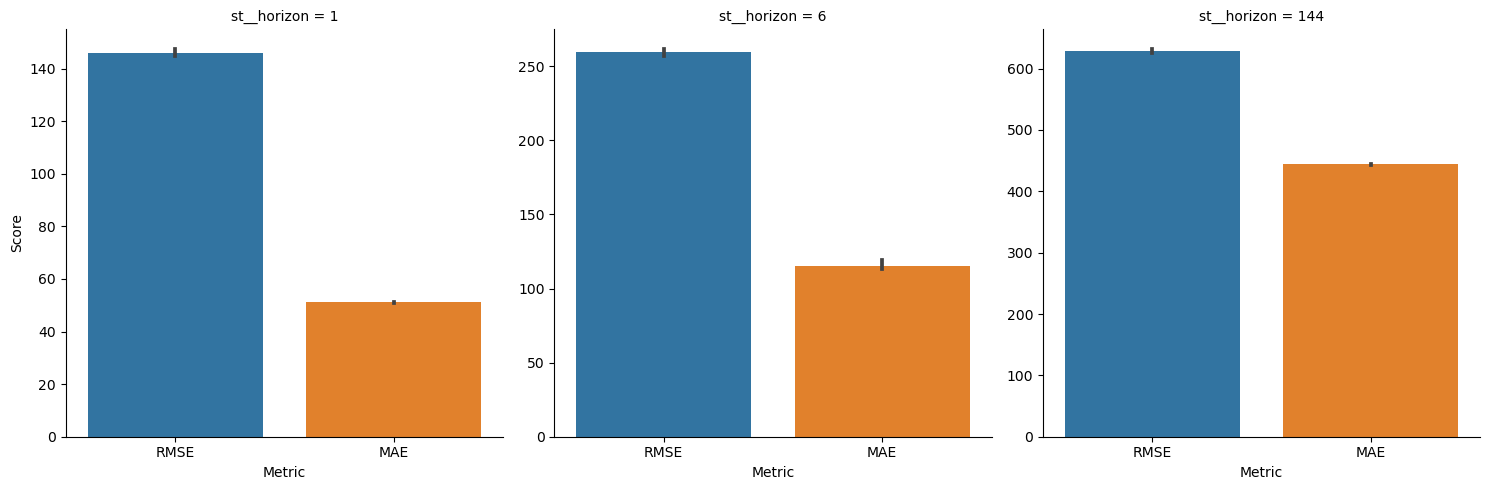

In [14]:
vis.plot_gridsearch(
    results_df=grid_search_xgb.results,
    hue=None,
    col="st__horizon",
    row=None,
    sharey=False,
)

## 4. Neural Network

**Explanation of the model:**
- still supervised learning problem 
- advantages in comparison with linear regression: polynomial features not necessary

In [15]:
# nn_pipe = Pipeline(
#     [
#         #("normalizer", Normalizer()),
#         ("st", SupervisedTransformer()),
#         ("Model", NeuralNetwork()),
#     ]
# )

# grid_search_nn = GridSearch(nn_pipe, param_grid)
# grid_search_nn.fit(X_train, y_train, X_test, y_test)